<a href="https://colab.research.google.com/github/lucas-azdias/Conteudo-Universidade/blob/master/Ci%C3%AAncia%20da%20Computa%C3%A7%C3%A3o/6%C2%BA%20Per%C3%ADodo/Aprendizagem%20de%20M%C3%A1quina/%5BTAREFAS%5D/Avalia%C3%A7%C3%A3o%20Somativa%2002%20(TDE2)/T2%20-%20Aprendizado%20de%20M%C3%A1quina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor (MRI Scans)**

Classify MRI scans as glioma, meningioma, pituitary, or healthy

https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans/data

#Imports e funções basicas


In [1]:
!pip install -q kaggle

In [2]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from keras.optimizers import Adam
from sklearn import metrics
from google.colab import files
import cv2 #opencv library
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import sys
import os
import shutil
import random

np.set_printoptions(suppress=True) #evita notacao cientifica

seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

In [3]:
!kaggle datasets download -d rm1000/brain-tumor-mri-scans -p /content

Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 94% 221M/236M [00:01<00:00, 162MB/s]
100% 236M/236M [00:02<00:00, 120MB/s]


In [4]:
%%capture
!unzip brain-tumor-mri-scans.zip -d dataset

##Funções


In [5]:
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

#Preparação do dataset

In [6]:
# Caminho para a pasta com as imagens
caminho_das_imagens = '/content/dataset'
pasta_treino = '/content/train'
pasta_teste = '/content/test'

##Balanceamento de classes


Distribuição das classes:
Classe glioma: 1621 imagens
Classe healthy: 2000 imagens
Classe pituitary: 1757 imagens
Classe meningioma: 1645 imagens


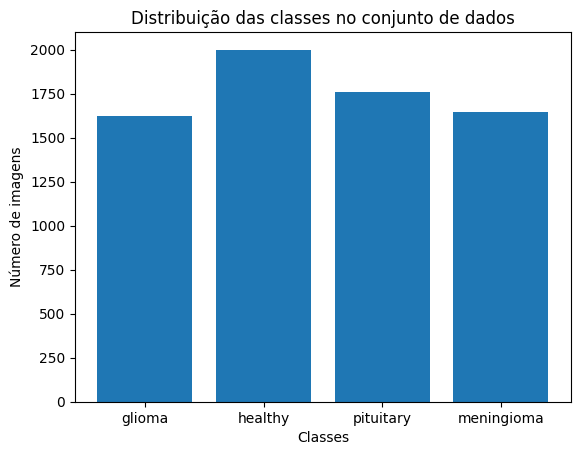

In [7]:
class_counts = {}
for class_name in os.listdir(caminho_das_imagens):
  class_path = os.path.join(caminho_das_imagens, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

# Mostrar o balanceamento das classes
print("Distribuição das classes:")
for class_name, count in class_counts.items():
  print(f"Classe {class_name}: {count} imagens")

# Você pode também plotar um gráfico de barras para visualizar a distribuição
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Número de imagens")
plt.title("Distribuição das classes no conjunto de dados")
plt.show()

##Separando treino e teste

In [8]:
# Verifica se a pasta existe e remove
if os.path.exists(pasta_treino):
    shutil.rmtree(pasta_treino)  # Remove a pasta e todo o conteúdo
    print(f'Pasta "{pasta_treino}" removida com sucesso.')

# Verifica se a pasta existe e remove
if os.path.exists(pasta_teste):
    shutil.rmtree(pasta_teste)  # Remove a pasta e todo o conteúdo
    print(f'Pasta "{pasta_teste}" removida com sucesso.')

# Cria as pastas de treino e teste, se não existirem
os.makedirs(pasta_treino, exist_ok=True)
os.makedirs(pasta_teste, exist_ok=True)

# Define a proporção de divisão
train_ratio = 0.7

# Itera por cada subpasta (classe)
for classe in os.listdir(caminho_das_imagens):
    caminho_classe = os.path.join(caminho_das_imagens, classe)

    # Verifica se é uma pasta
    if os.path.isdir(caminho_classe):
        # Cria as subpastas de treino e teste para cada classe
        os.makedirs(os.path.join(pasta_treino, classe), exist_ok=True)
        os.makedirs(os.path.join(pasta_teste, classe), exist_ok=True)

        # Lista todas as imagens na subpasta da classe
        imagens = [f for f in os.listdir(caminho_classe) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Embaralha a lista de imagens
        random.shuffle(imagens)

        # Calcula o índice de corte para treino/teste
        split_index = int(len(imagens) * train_ratio)

        # Divide as imagens em treino e teste
        imagens_treino = imagens[:split_index]
        imagens_teste = imagens[split_index:]

        # Move as imagens de treino
        for imagem in imagens_treino:
            shutil.copy(os.path.join(caminho_classe, imagem), os.path.join(pasta_treino, classe, imagem))

        # Move as imagens de teste
        for imagem in imagens_teste:
            shutil.copy(os.path.join(caminho_classe, imagem), os.path.join(pasta_teste, classe, imagem))

print("Divisão de imagens em treino e teste concluída com sucesso.")

Divisão de imagens em treino e teste concluída com sucesso.


In [9]:
total_treino = len(os.listdir(pasta_treino + '/glioma')) + len(os.listdir(pasta_treino + '/healthy')) + len(os.listdir(pasta_treino + '/meningioma')) + len(os.listdir(pasta_treino + '/pituitary'))
print('Treino:', total_treino)

total_teste = len(os.listdir(pasta_teste + '/glioma')) + len(os.listdir(pasta_teste + '/healthy')) + len(os.listdir(pasta_teste + '/meningioma')) + len(os.listdir(pasta_teste + '/pituitary'))
print('Teste:', total_teste)

print('Total geral:', total_treino + total_teste)

Treino: 4914
Teste: 2109
Total geral: 7023


##Carregando treino, validação e teste


In [10]:
batch_size_ = 32
input_shape_ = (512,512,3) # RESNET50
# input_shape_ = (96,96,3) # VGG16


train_ds = tf.keras.utils.image_dataset_from_directory(
  pasta_treino,
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  pasta_treino,
  validation_split=0.2,
  subset="validation",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

test_ds = tf.keras.utils.image_dataset_from_directory(
  pasta_teste,
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)

Found 4914 files belonging to 4 classes.
Using 3932 files for training.
Found 4914 files belonging to 4 classes.
Using 982 files for validation.
Found 2109 files belonging to 4 classes.
['glioma', 'healthy', 'meningioma', 'pituitary']


##Visualizando dataset


['glioma' 'healthy' 'meningioma' 'pituitary']


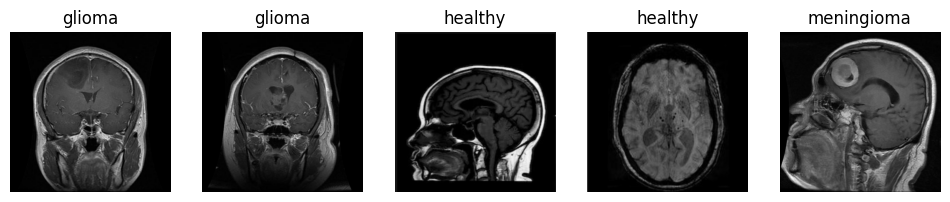

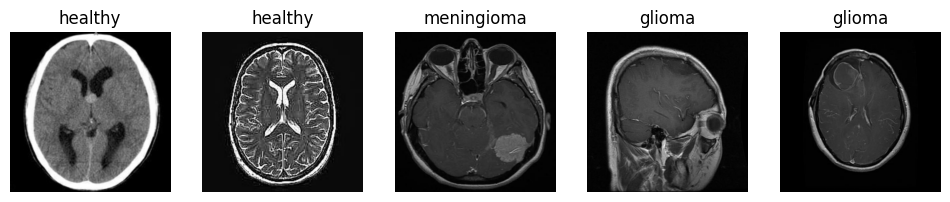

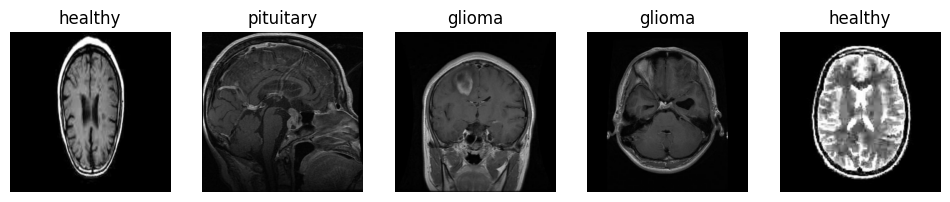

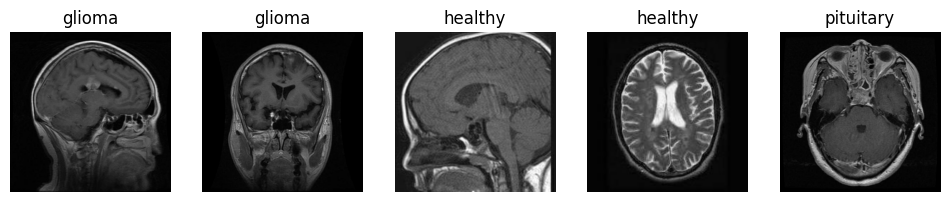

In [11]:
print(class_names)
for img,lbl in train_ds.take(4):

  titles = []
  # print(lbl)
  for i in lbl:
    titles.append(class_names[i])

  plot_sidebyside(img[:5]/255.,titles[:5])

##Data augmentation

In [12]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(input_shape_[0],
                                  input_shape_[1],
                                  3)),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(.3),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###Imagens geradas por data augmentation

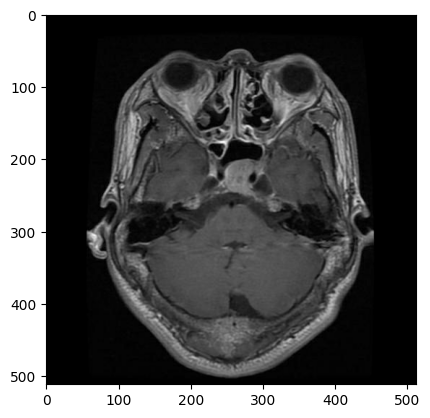

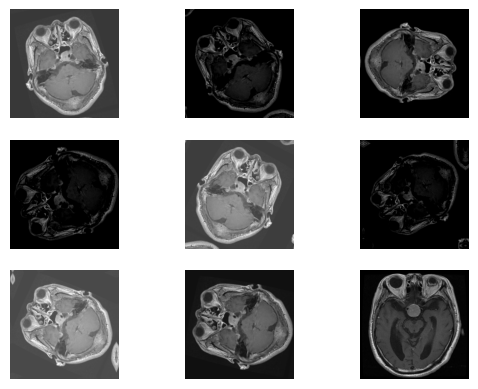

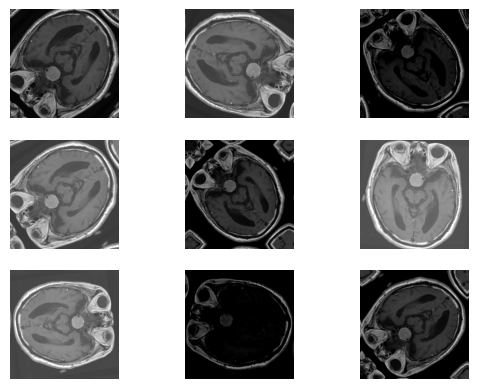

In [13]:
for images, _ in train_ds.take(2):
  plt.imshow(images[7].numpy().astype("uint8"))
  plt.show()
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[7].numpy().astype("uint8"))
    plt.axis("off")

# Definindo o modelo (precisa escolher)

**Execute apenas um modelo abaixo!**

##Modelo RESNET50

In [14]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                        input_tensor=tf.keras.layers.Input(input_shape_),
                                                      classes=num_classes)
conv_layers.trainable = False
conv_layers.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

##Modelo VGG16

In [ ]:
conv_layers =  tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,
                                                        input_tensor=tf.keras.layers.Input(input_shape_),
                                                      classes=num_classes)
conv_layers.trainable = False
conv_layers.summary()

#Treinamento do modelo

##Freezing


In [15]:
conv_layers.trainable=False
n_layers = len(conv_layers.layers)

##Adequação do modelo

In [16]:
inputs = layers.Input(shape=input_shape_)
x = data_augmentation(inputs)
x = conv_layers(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/my_model/model_checkpoint.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_acc' ,
    mode='max',
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc",
    patience=2,
    verbose=1,
    mode='max',
    restore_best_weights=True,
)

epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - acc: 0.7180 - loss: 0.6908
Epoch 1: val_acc improved from -inf to 0.89511, saving model to /content/my_model/model_checkpoint.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 107s 699ms/step - acc: 0.7188 - loss: 0.6890 - val_acc: 0.8951 - val_loss: 0.2803
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - acc: 0.8847 - loss: 0.2771
Epoch 2: val_acc improved from 0.89511 to 0.90937, saving model to /content/my_model/model_checkpoint.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 101s 486ms/step - acc: 0.8848 - loss: 0.2770 - val_acc: 0.9094 - val_loss: 0.2603
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - acc: 0.9195 - loss: 0.2122
Epoch 3: val_acc improved from 0.90937 to 0.93686, saving model to /content/my_model/model_checkpoint.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 90s 554ms/step - acc: 0.9195 - loss: 0.2122 - val_acc: 0.9369 - val_loss: 0.1864
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - acc: 0.9251 - loss: 0.1961


##Fine-tuning

In [17]:
conv_layers.trainable=True
n_layers = len(conv_layers.layers)

for j in range(0,n_layers-10):
    conv_layers.layers[j].trainable = False

for j in range(n_layers-10,n_layers):
    conv_layers.layers[j].trainable = True

conv_layers.summary()

model.compile(optimizer=Adam(1e-5), loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_callback, early_stopping_callback])

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - acc: 0.9450 - loss: 0.1379
Epoch 1: val_acc did not improve from 0.95519
123/123 ━━━━━━━━━━━━━━━━━━━━ 100s 670ms/step - acc: 0.9452 - loss: 0.1376 - val_acc: 0.9481 - val_loss: 0.1413
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - acc: 0.9796 - loss: 0.0642
Epoch 2: val_acc improved from 0.95519 to 0.95825, saving model to /content/my_model/model_checkpoint.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 123s 588ms/step - acc: 0.9796 - loss: 0.0642 - val_acc: 0.9582 - val_loss: 0.1206
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - acc: 0.9915 - loss: 0.0440
Epoch 3: val_acc did not improve from 0.95825
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 579ms/step - acc: 0.9915 - loss: 0.0440 - val_acc: 0.9582 - val_loss: 0.1153
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - acc: 0.9942 - loss: 0.0324
Epoch 4: val_acc improved from 0.95825 to 0.96232, saving model to /content/my_model/model_checkpoint.weights.h5
123/123 ━━━━━━━━━━

#Avaliação do modelo

In [18]:
model.evaluate(test_ds)

66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 613ms/step - acc: 0.9678 - loss: 0.1182


[0.11643373966217041, 0.9677572250366211]

##Plot histórico


- Overfiting: validation accuracy stops increasing when compared to training accuracy

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


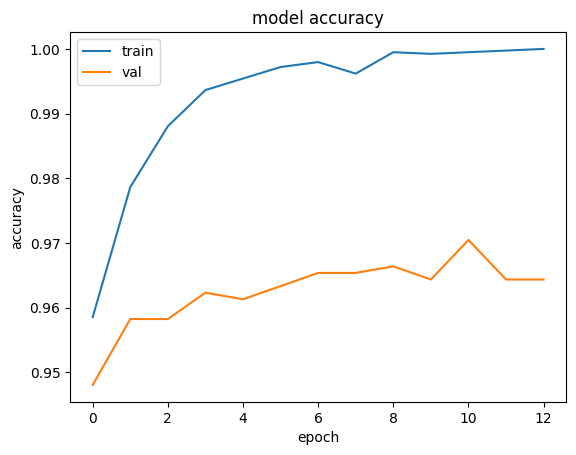

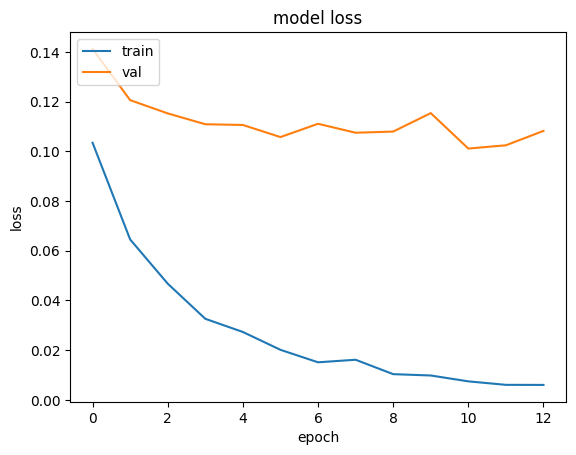

In [19]:
plot_history(history)

##Matriz de confusão

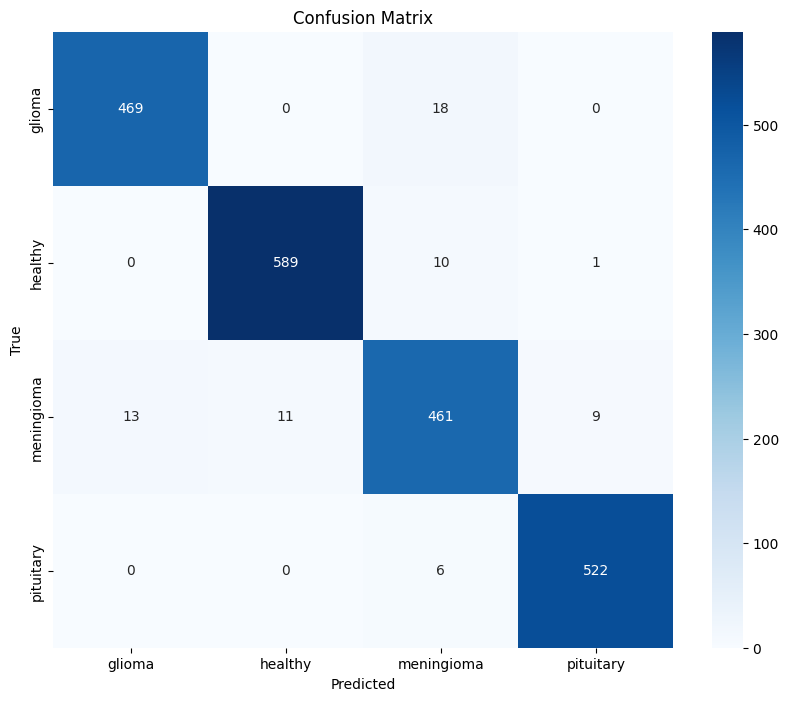

              precision    recall  f1-score   support

      glioma       0.97      0.96      0.97       487
     healthy       0.98      0.98      0.98       600
  meningioma       0.93      0.93      0.93       494
   pituitary       0.98      0.99      0.98       528

    accuracy                           0.97      2109
   macro avg       0.97      0.97      0.97      2109
weighted avg       0.97      0.97      0.97      2109



In [20]:
y_true = []
y_pred = []

# Remove a saída de texto
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# Predições
for images, labels in test_ds:
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)
  y_true.extend(labels.numpy())
  y_pred.extend(predicted_labels)

# Restaura a saída padrão
sys.stdout = original_stdout

cm = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

##Teste em algumas imagens aleatórias obtidas pelo Google

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
['glioma' 'healthy' 'meningioma' 'pituitary']


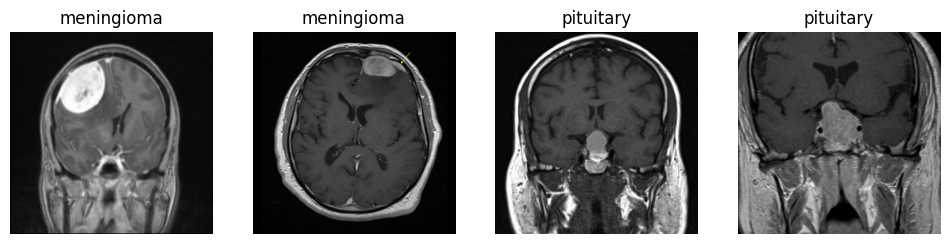

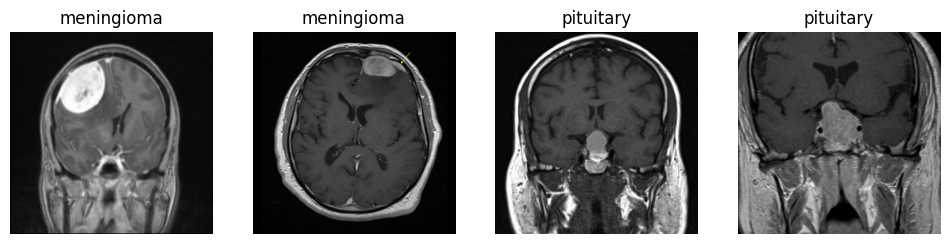

1: TRUE=meningioma PRED=meningioma
2: TRUE=meningioma PRED=meningioma
3: TRUE=pituitary PRED=pituitary
4: TRUE=pituitary PRED=pituitary


In [21]:
imlist = []
impred = []

# Meningioma
url_img = "https://www.doneurosurgery.com/uploads/7/6/8/0/76801071/1471609124.png"
path_img = '/content/img1.png'
Image.open(BytesIO(requests.get(url_img).content)).save(path_img)
img = cv2.imread(path_img)
img = cv2.resize(img, input_shape_[:2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imlist.append(img)
impred.append(("meningioma", class_names[np.argmax(model.predict(np.array([img])))]))

# Meningioma
url_img = "http://www.svuhradiology.ie/wp-content/uploads/2015/04/MeningiomaT1post-897x1024.jpg"
Image.open(BytesIO(requests.get(url_img).content)).save(path_img)
img = cv2.imread(path_img)
img = cv2.resize(img, input_shape_[:2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imlist.append(img)
impred.append(("meningioma", class_names[np.argmax(model.predict(np.array([img])))]))

# Pituitary
url_img = "https://eyewiki.org/w/images/e/ed/PituitaryAdenoma.JPG"
path_img = '/content/img3.jpg'
Image.open(BytesIO(requests.get(url_img).content)).save(path_img)
img = cv2.imread(path_img)
img = cv2.resize(img, input_shape_[:2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imlist.append(img)
impred.append(("pituitary", class_names[np.argmax(model.predict(np.array([img])))]))

# Pituitary
url_img = "https://prod-images-static.radiopaedia.org/images/7355888/61dd976928b7b5ca52b7013c4e0773_big_gallery.jpg"
path_img = '/content/img4.jpg'
Image.open(BytesIO(requests.get(url_img).content)).save(path_img)
img = cv2.imread(path_img)
img = cv2.resize(img, input_shape_[:2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imlist.append(img)
impred.append(("pituitary", class_names[np.argmax(model.predict(np.array([img])))]))

print(class_names)
plot_sidebyside(imlist, [x[0] for x in impred])
plot_sidebyside(imlist, [x[1] for x in impred])

for i in range(len(impred)):
  print(f"{i + 1}: TRUE={impred[i][0]} PRED={impred[i][1]}")

#Discussão


O modelo foi treinado utilizando um dataset com um total de 7.023 imagens de resonancias magneticas realizadas em pessoas saudáveis e pessoas com três tipos de tumores cerebrais.

* **Saudáveis**: 2000 imagens
* **Glioma**: 1621 imagens
* **Meningioma**: 1645 imagens
* **Pituitary**: 1757 imagens


Para entender o processo de separação do dataset:
* Primeiro separamos duas bases, treino e teste
  * **Treino**: 4914 imagens
  * **Teste**: 2109 imagens

* Então separamos a base de treino novamente, em treino e validação:
 * **Treino**: 3932
 * **Validação**: 982

* Nossa base de testes ficou com essa quantidade de classes:
  * Glioma: 487
  * healty: 600
  * meningioma: 494
  * pituitary: 528

Utilizamos um processo de **Data augmentation** durante o treinamento, devido a natureza do problema, que fornece quantidade limitada de informação para treinamento.

Fizemos uma comparação com e sem Data Augmentation, e verificamos uma melhora significativa na acurácia do modelo, não houve aumento significativo no tempo de treinamento.

Com os valores de validação, comparamos dois modelos pré-treinados para utilizar um método de transfer-learning, VGG16 e Resnet50.

O modelo com resnet50 obteve uma melhor performance e então seguimos com ele para as próximas etapas.

Na etapa de fine-tuning, habilitamos o treinamento das utimas 10 camadas do modelo e então recompilamos o modelo utilizando o ativador Adam com um learning rate baixo para evitar o over-fitting.

O modelo foi capaz de classificar corretamente a maioria das classes existentes no dataset de teste, mantendo uma acurácia próxima do que foi visto durante o treinamento e validação. A matriz de confusão mostra uma tendência a correta classificação das imagens. Isso trás indicios da convergência do modelo.

Entretanto, pela pequena quantidade de dados tanto no dataset de treino, quanto no de teste, mesmo com o processo de data augmentation é possível que tenha ocorrido o overfitting do modelo.

Para uma melhor validação do modelo seriam necessárias mais imagens.





##Análise dos resultados

Verificamos uma confusão do modelo ao classificar imagens de gioma e meningioma, devido a uma maior simiralidade entre os dois casos. Para os casos de imagens de pessoas saudáveis, houve um ótimo desempenho, já que essas imagens são mais distinguiveis, na maioria das vezes, das pessoas com tumores.




#Salvando modelo

In [ ]:
model.save('/content/my_model/model.keras')